In [3]:
import numpy as np
import pdb
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'



from IPython.core.display import HTML
def css_styling():
    styles = open("custom.css", "r").read() #or edit path to custom.css
    return HTML(styles)
css_styling()


# <center> Math 579: Assignment 3 </center>

In this assignment we will be using the finite element method to obtain solutions to the Poisson equation with Dirichlet boundary conditions,

\begin{align} \tag{1}
-\Delta u &= f  &\text{    in    } \Omega 
\\
u &= g &\text{    on    } \partial\Omega
\end{align}


where $\Omega \subset \mathbb{R}^2$ bounded, $f \in L^2\left(\Omega\right)$ and $g \in L^2(\partial\Omega)$. We will first devise an implementation that is able to handle at least one convex domain (such as a square or a triangle), a domain with a reentrant corner (such as an L-shaped domain), inhomogeneous Dirichlet boundary conditions, and a refinement procedure. The implementation will then be tested against a series of numerical experiments to see if the numerical results agree with the theory.

### <center> Weak Formulation </center>
----
    
In order to account for the inhomogeneous boundary condition, we first let $w = u - g$ and consider the function space,

\begin{equation*}
H^1_{g} = \left\{ u \in H^1(\Omega) | \;\; u\rvert_{\partial \Omega} = g \right\}
\end{equation*}

Provided that g admits an extension, G, to the whole domain, this allows us to reformulate the weak problem as: find $w \in H^{1}_0 \left(\Omega\right)$ s.t.

\begin{equation*} \tag{2}
\int_{\Omega} \nabla w \cdot \nabla v = \int_{\Omega} f v   - \int_{\Omega} \nabla G \cdot \nabla v, \;\; \forall \,v \in H^1_0(\Omega)  
\end{equation*}


### <center> Galerkin Discretization </center>
----

We consider discrete formulation of the problem begins by  the finite dimensional subspaces $X_n \subset H^1(\Omega)$ and $X^0_n \subset X_n \cap H^1_0(\Omega)$. We partition the domain using a conforming triangulation $P$, containing $N$ vertices. As an interpolation basis for $X_n$, we take the nodal interpolants $\left\{\phi_i \right\}_{i}$ where $i = 1,2,..., N$. The basis elements are linear in every element $\tau \in P$ and satisfy:

\begin{equation*}
\phi_i(x_k) = \delta_{i,k}
\end{equation*}

where $x_k$ is the coordinate of the $k^{th}$ vertex. The subspace $X^0_n$ is spanned by $\left\{\phi_k \right\}_{k} \subset \left\{\phi_i \right\}_{i}$, for $k \in I$ where $I$ is an index set containing only labels for the interior nodes. The extension of the Dirichlet condition is then given by,

\begin{equation*}
G(x) = \sum_{k=1}^N g_k \phi_k(x)
\end{equation*}

and the numerical solution is given by

\begin{equation*}
U(x) = \sum_{i \in I} x_k\phi_k(x) + G(x)
\end{equation*}

where the $x_k$ come from the solution of the linear system

\begin{equation*}
Ax = b.
\end{equation*}

This linear system represents the discretization of the weak formulation given by (2). More explicitly, the entries of the stiffness matrix are given by,

\begin{equation*}
A_{ik} = \sum_{\tau \in P} \int_{\tau} \nabla\phi_i \cdot \nabla \phi_k
\end{equation*}

and the entries of the RHS are given by

\begin{equation*}
\sum_{\tau \in P} \int_{\tau} f\phi_i - \sum_{k = 1}^N G_k \sum_{\tau \in P} \int_{\tau} \nabla\phi_i \cdot \nabla \phi_k . 
\end{equation*}


The assembly of the stiffness matrix and RHS is done exactly as described in the reference [1]. We now present code used to implement the numerical solution of (1), with sufficient commentary on the subtleties that arise.  

---

## <center> Data structures and routines </center>

We first consider triangulating a square domain in $\mathbb{R}^2$ with corners $(0,0), (0,1), (1,0), (1,1)$ and an equal number of nodes along each axis. The methodology for the implementation is to define classes for the aspects that wish to be sufficiently general and functions for the aspects that are problem specific, such as the triangulation and boundary conditions.



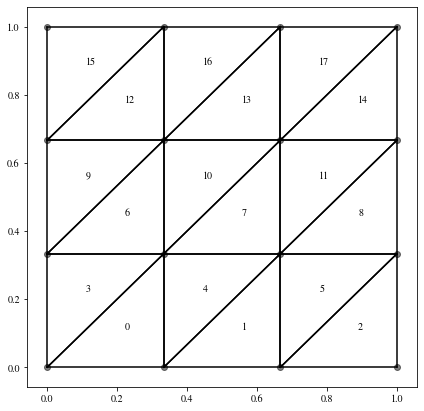

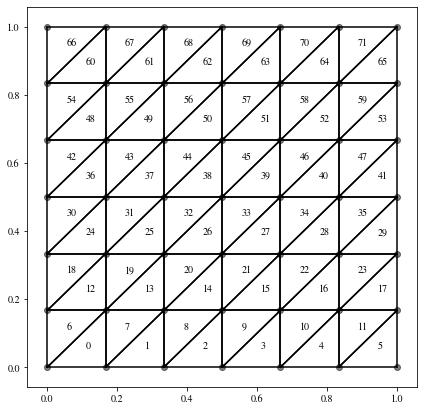

In [4]:
%matplotlib inline
# Triangulation and Refinement Code

def Square_Triangulate(N):

    x_coords = np.linspace(0, 1, N, endpoint = True)
    y_coords = np.linspace(0, 1, N, endpoint = True)

    # Put this into a meshgrid for easier access to coordinate values.

    [X,Y] = np.array(np.meshgrid(x_coords, y_coords))
    #Put this in a more convenient form:
    Nodes = np.zeros([N**2, 3])
    Nodes[:,0], Nodes[:,1], Nodes[:,2] = np.arange(0,int(N**2), dtype = int), X.reshape([N**2,]), Y.reshape([N**2,])

    E_u1 = []
    E_u2 = []
    E_u3 = []
    for i in range(0, N-1):
        b = i*N  #beginning in nodes
        l_row = Nodes[b:b+N,0].copy()
        u_row = Nodes[b+N:b+2*N,0].copy()
        E_u1 += list(l_row[0:N-1])
        E_u2 += list(l_row[1:N])
        E_u3 += list(u_row[1:N])
        E_u1 += list(l_row[0:N-1])
        E_u2 += list(u_row[0:N-1])
        E_u3 += list(u_row[1:N])
        
        
    M = len(E_u1)
    E = np.zeros([M, 4], dtype = int)  
    E[:,0] = np.arange(0, M, dtype = int) # "--------=----------"
    E[0:len(E_u1),1] = E_u1
    E[0:len(E_u2),2] = E_u2
    E[0:len(E_u3),3] = E_u3

    return E, Nodes, [X,Y]


# Function to plot mesh
def Mesh_Plot(E, Nodes, boundary = None):
    """
    Function to output plot of the mesh created with labelled elements
    """
    fig = plt.figure(figsize = (7,7))

    #First create scatter plot with all the nodes
    
    plt.scatter(Nodes[:,1], Nodes[:,2], c = "k", alpha = 0.5)
    
    #Then plot lines and label elements
    for row in E:
        num = row[0]
        xs = Nodes[row[1::],1]
        ys = Nodes[row[1::], 2]
        # calculate center of element
        x_c, y_c = np.sum(xs)/3, np.sum(ys)/3                     
        plt.text(x_c, y_c, s = "%d" %num, fontsize = 10)
                                                              
        # Add lines connecting the nodes for each element
        plt.plot([xs[0], xs[1]], [ys[0], ys[1]], c= "k")
        plt.plot([xs[1], xs[2]], [ys[1], ys[2]], c= "k")
        plt.plot([xs[2], xs[0]], [ys[2], ys[0]], c= "k")
    
    if boundary != None:
        plt.scatter(Nodes[boundary,1], Nodes[boundary, 2], c = "b")
        
    return



def red_refinement(N,num):
    """
    N = starting number of nodes, i  = number of refinements
    returns an array of # num of nodes along each axis at each stage
    """
    ref = [N]
    for n in range(num-1):
        ref.append(2*ref[n]-1)

    return ref

Ns = red_refinement(4, 2)

E, Nodes, Mesh = Square_Triangulate(Ns[0])
Mesh_Plot(E, Nodes)

E, Nodes, Mesh = Square_Triangulate(Ns[1])
Mesh_Plot(E, Nodes)


---
A triangulation of the square along with one refinement. 

---

Below are the classes to assemble the local stiffness matrix, load vector, and the algorithm to solve the linear system resulting from the discretization of the weak formulation. 

---

In [5]:

# Code to assemble elemental stiffness matrices:
class Stiffness(object):

    def __init__(self, Elements, Nodes):
        self.E = Elements
        self.Nodes = Nodes
        return

    def loc(self, element = 0):
        # returns local stiffness matrix for a certain element
        N_s = self.E[element, :][1::]

        x_s = self.Nodes[N_s, 1]
        y_s = self.Nodes[N_s, 2]

        T = 0.5*abs(((x_s[1]- x_s[0])*(y_s[2]-y_s[0]) - \
                 (x_s[2]-x_s[0])*(y_s[1]-y_s[0])))

        Gg = np.linalg.inv(np.array([[1,1,1],x_s,y_s]))
        g = np.array([[0,0],[1,0],[0,1]])
        G = np.matmul(Gg, g)
        # M = T*np.matmul(G, G.T)
        M = (0.5)*abs(np.linalg.det(np.array([[1,1,1],x_s,y_s])))*np.matmul(G, G.T)

        return M

#------------------------------------------------------------------------------

# RHS assembly

class RHS(object):
    """
    Class to store the RHS of our problem,
    input is the forcing function (RHS) of the problem

    input: F[X,Y]: Omega \to R^N,
    N is the number of nodes, X,Y \in R^{N^2}.
    """

    def __init__(self, f, g, elements, nodes):
        # make sure these are callable
        self.f = f
        self.g = g
        self.E = elements
        self.Nodes = nodes
        return

    def b(self, boundary):
       # Calculates volume force at every node
        F_vol = np.zeros([len(self.Nodes[:,0]),])
        for e in range(len(self.E[:,0])):
            n_s = self.E[e, 1::]
            X,Y = self.Nodes[n_s, 1], self.Nodes[n_s,2]
            Area = 0.5*abs((X[1] - X[0])*(Y[2]-Y[0]) - (X[2]-X[0])*(Y[1]-Y[0]))
            i = 0
            for n in n_s:
                F_vol[n] += (1/3)*Area*self.f(X[i], Y[i])
                i +=1

        return F_vol
    
    

def on_boundary(Nodes):

    bn = [] # Boundary nodes
    eps = 1e-11
    for i in range(len(Nodes[:,0])):
        n, x, y = Nodes[i,0], Nodes[i,1], Nodes[i,2]

        # This is just for the square

        if (x < eps) or x > (1 - eps) or y < eps or y > (1-eps):
            bn.append(int(n))

    return bn




In [11]:
#------------------ Algorithm implementation--------------------------------
def Solve(mesh_func, N, U_exact, F, boundary, size = False):


    # Set up computational domain
    E, Nodes, Mesh = mesh_func(N)

    # Identify boundary
    bn = boundary(Nodes)
    
    NN = N**2
    
    if size != False:
        NN = size
    
        
    M = Stiffness(E, Nodes)
    rhs = RHS(f = F, g = U_exact, elements = E, nodes = Nodes)

    # Extension of initial condition is just U itself.

    #Assemble full Stiffness matrix and then delete boundary data:
    A = np.zeros([NN,NN], dtype = "float")
    for e in E[:,0]:
        N_s = E[e,1::]
        M_loc = M.loc(e)
        for i in range(3):
            for j in range(3):
                A[N_s[i], N_s[j]] += M_loc[i,j]

    B = rhs.b(boundary = bn)

    # remove nodes corresponding to boundary data:

    # for the array it's a bit trickier
    # first define a list without the elements in bn
    nns = np.arange(0, len(Nodes[:,1]))

    not_bn = np.array([x for x in nns if x not in bn])

    #delete these rows and columns
    A_in = A[not_bn,:][:,not_bn]

    # Apply M to G    
    if size == False:
        G_init = U_exact(Nodes[:,1], Nodes[:,2])
        u_D = G_init.copy()
    else:
        G_init = U_exact(Nodes[:,1], Nodes[:,2])
        u_D = G_init.copy()
        
    # Set G to zero except for the boundary.
    u_D[not_bn] = 0.
    AG = np.matmul(A[not_bn,:], u_D)

    B_in = B[not_bn] - AG


    # Finally invert
    #U_in = np.matmul(np.linalg.inv(A_in), B_in)
    U_in = np.linalg.solve(A_in, B_in)
    
    # Combine with boundary data:
    U  = np.zeros([NN,], dtype = "float")
    U[not_bn] = U_in
    U += u_D

    return U, G_init




 ## <center> Numerical Experiments</center>
 
 With the numerical implementation now developed, we seek to estimate the $H^1\left(\Omega\right)$ error of the numerical solution. The Poisson equation we consider for the square domain is given by, 
 

\begin{align}
-\Delta u &= 10\sin(3x)\cos(y)  &\text{    in    } \Omega 
\\
u &= \sin(3x)\cos(y) &\text{    on    } \partial\Omega
\end{align}


with exact solution $u_{ex} = \sin(3x)\cos(y)$. It is apparent that the exact solution of this problem is the boundary condition extended to the entirety of the domain. Thus, if were to extend the boundary condition to the whole domain, $w = u - g$ would be identically 0. We thus consider an extension using a smooth cut-off function $g\chi$ where $\chi = 1$ on $\partial \Omega$ and $\chi = 0$ on $\omega \subset \Omega$ where $\omega$ contains all the interior nodes of the triangulation.

---
**Expected convergence rate**:

Denote the nodal interpolant, $I_p: C(\Omega) \to X_h$. The following error estimate follows from our analysis in class,

\begin{equation*}
\left\lVert u - I_p(u) \right\rVert_{k,p} \leq C h^{d-k}\lVert u \rVert_{m,p}
\end{equation*}

where d-1 is the order of the polynomial approximation within each element. Since we are considering linear interpolation, a bound for the $H^1$ error is given by,

\begin{equation*}
\left\lVert u - I_p(u) \right\rVert_{1,2} \leq C h \lVert u \rVert_{2,2}
\end{equation*}

thus we expect a linear convergence rate in the $H^1$ norm with respect to the area of the largest triangle. If we only measured the $L^2$ error of our solution then, taking k=0 gives us:

\begin{equation*}
\left\lVert u - I_p(u) \right\rVert_{L^2} \leq C h^2 \lVert u \rVert_{2,2}
\end{equation*}

thus we expect quadratic convergence rate with respect to the area of the largest triangle when measuring the error in the $L^2$ norm. We note also that since our solution is smooth that the contribution from the $H^2$ norm of $u$ is bounded. 

---

 **Evaluting the error**

The $H^1$ and $L^2$ error are given as follows:


\begin{equation*}
\left \lVert v \right \rVert_{\ell^2(\Omega)}^2 = \sum_{i,k} v_i v_k \left< \phi_i, \phi_k \right> = v^T M v
\end{equation*}

\begin{equation*}
\left \lVert \nabla v \right \rVert_{\ell^2(\Omega)}^2 = \sum_{i,k} v_i v_k \left< \nabla\phi_i, \nabla\phi_k \right> = v^T A v
\end{equation*}

where $M$ is the mass matrix and $A$ is the stiffness matrix of the finite element system. To construct these matrices, we denote $u - I_p(u_h) \approx I_p(u - u_h) = e$. Then the mass and stiffness matrices are formulated as follows,   


\begin{equation*}
\begin{aligned}
\left\lVert e \right\rVert_{H^1(\Omega)}^2 & = \int_{\Omega} |\nabla e|^2 + \int_{\Omega}|e|^2
\\
&= \sum_{\tau \in P} \int_{\tau} \sum_{i} \sum_{j} e_i \phi_i(x) e_j \phi_j(x) +  \nabla(e_i \phi_i(x) e_j \phi_j(x))
\\
& = \sum_{\tau \in P} \sum_{i} \sum_{j} e_i e_j(<\phi_i, \phi_j> + <\nabla \phi_i, \nabla \phi_j>)
\\
& = e^T M e + e^T A e
\end{aligned}
\end{equation*}

The construction of the stiffness matrix was given in the reference and has already been computed in the formulation of the linear system, the mass matrix however was not. To compute the mass matrix, we use quadrature following a procedure outlined in [2] (pg. 60). The local mass matrix can be shown to be given by,

\begin{equation*}
A_{ij} = \int_{\tau} \phi_i\phi_j  = \frac{1}{12}(1 + \delta_{i,j})|\tau|
\end{equation*}

the code to assemble this matrix and evaluate the $H^1$ norm is given by the function `H1_norm()` below. 

It should be remarked that we project the analytic solution using the interpolation operator as well. When actually computing the error we refine the mesh, project the analytic solution on this finer mesh and then perform a linear interpolation from the coarser mesh with our numerical solution. The error, $e$, is then given by the difference between the interpolated numerical solution and the analytic solution as evaluated at the vertices of the finer mesh. In order to accomplish this, we have created a linear interpolation class. The implementation is given below.

---

In [12]:
import scipy.spatial
class Linear_interp(object):
    
    """
    Class to perform linear interpolation on a triangulated grid
    Nodes, Elements and Values at the vertices are used to initialize
    interpolator.
    """
    
    def __init__(self, elements, nodes, U):
        self.nodes = nodes.copy()
        self.E = elements.copy()
        self.u = U.copy()
        return
    
    def eval(self, x_q, y_q, point = False):
        """
        Inputs x_q, y_q are the query points in the form of 1D arrays.
        
        Output: array of points corresponding to a linear interpolation
        of the mesh function
        """
        
        xs = self.nodes[:,1]
        ys = self.nodes[:,2]
        XY_C = np.zeros([len(xs),2])
        XY_C[:,0] = xs
        XY_C[:,1] = ys
            
        mytree = scipy.spatial.cKDTree(XY_C)
        
        XY_q = np.zeros([len(x_q),2])
        XY_q[:,0] = x_q
        XY_q[:,1] = y_q


        # now query points in triangulation,
        # the k argument asks for 3 nearest neighbours
        dist, indices = mytree.query(x = XY_q, k = 3)

#-------Can now perform linear interpolation with these distances and indices------------

        # Solve linear system for the weights in barycentric coordinates
        # Loop over rows:
        i = 0
        u_ref = []

        for row in indices:
            u_p = np.array(self.u[row])
            A = np.array([np.array(xs[row]), np.array(ys[row]),[1,1,1]])

            if np.linalg.cond(A) < 1e11:
                B = np.linalg.inv(A)
                b = np.array([x_q[i], y_q[i],1])
                w = np.matmul(B,b)
                u_av = (1/np.sum(w))*(np.sum(u_p*w))
                u_ref.append(u_av)
            else:
                u_av = (1/np.sum(dist[i]))*np.sum((np.array(dist[i])*u_p))
                u_ref.append(u_av)

            i+=1

        return np.array(u_ref)

The interpolation scheme uses scipy's cKDTree to query the closest nodes to a given point at which we wish to evaluate. It then calculates the barycentric weights for the nodal values of U within that triangle, by solving the linear system:


$$\begin{bmatrix}
x_1 & x_2 & x_3 \\
y_1 & y_2 & y_3 \\
1 & 1 & 1 
\end{bmatrix}
\begin{bmatrix}
 w_1 \\
 w_2 \\
 w_2 
\end{bmatrix}
= 
\begin{bmatrix}
x_q\\
y_q \\
1
\end{bmatrix}
$$

where $(x_i, y_i)$ for $i = 1,2,3$ are the coordinates of the nearest nodes, $w_i$ are the weights, and $(x_q, y_q)$ is the query point. The value of $u(x_q, y_q)$ is then given as

$$ u(x_q, y_q) = \frac{1}{w_1 + w_2 + w_3}(w_1 u(x_1,y_1) + w_2 u(x_2,y_2) + w_3 u(x_3,y_3)) $$.

In order to ensure that the interpolation scheme is working correctly, we run a simple test by evaluating the $L^{\infty}$ error on a increasing number of points within the square. For each iteration a new interpolant class is created, we then refine it once and evaluate the $L^{\infty}$ error against the analytic exact solution for the function $u(x,y) = \sin(3x)\cos(y)$. The test is given below depicting $\mathcal{O}(N^2)$ convergence rate, where $N$ is the number of points along each axis, which is as expected. 

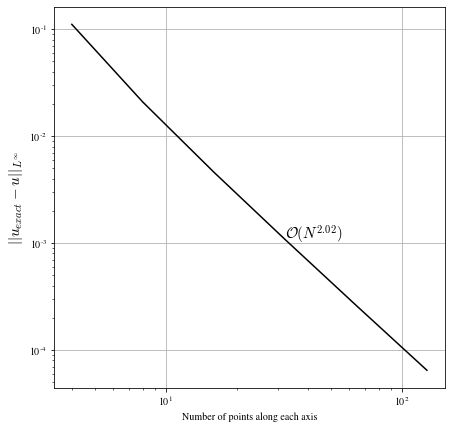

In [8]:
# Linear interpolation test
def uu_exact(x,y):

    return  np.sin(3*x)*np.cos(y) 


err = []
Ns = [4, 8, 16, 32, 64, 128]
for N in Ns:
    
    E, Nodes, Mesh = Square_Triangulate(N)
    U = uu_exact(Nodes[:,1],Nodes[:,2])
    L_dom = Linear_interp(elements = E, nodes = Nodes, U = U)
    E_r, Nodes_r, Mesh_r = Square_Triangulate(2*N)
    U_refine = L_dom.eval(Nodes_r[:,1], Nodes_r[:,2])
    
    Error = abs(uu_exact(Nodes_r[:,1],Nodes_r[:,2]) - U_refine)
    err.append(np.max(Error))
    
fig = plt.figure(figsize = (7,7))
m = np.log(err[-1]/err[-2])/np.log((Ns[-1]/Ns[-2]))

plt.loglog(Ns, err, c = "k")
plt.text(Ns[3], err[-3],r"$\mathcal{O}(N^{%1.2f})$" %(-m), fontsize = 15)
plt.xlabel("Number of points along each axis")
plt.ylabel(r"$||u_{exact} - u||_{L^{\infty}}$", fontsize = 15)
plt.grid()

In [13]:
def H1_norm(E, Nodes, U, which = None):

    #Assemble full Stiffness and Mass matrices
    N = len(Nodes[:,0])
    A = np.zeros([N,N], dtype = "float")
    M = Stiffness(E, Nodes)

    Mass = np.zeros([N,N], dtype = "float")
    Mass_loc = (1/12)*np.array([[2,1,1],[1,2,1],[1,1,2]])
    
    for e in E[:,0]:
        N_s = E[e,1::]
        [X,Y] = [Nodes[N_s, 1], Nodes[N_s,2]]
        J = abs((X[1] - X[0])*(Y[2]-Y[0]) - (X[2]-X[0])*(Y[1]-Y[0]))
        Area = 0.5*J
        mass_loc = Area*Mass_loc
        M_loc = M.loc(e)
        # Add entries to global stiffness and mass matrices
        for i in range(3):
            for j in range(3):
                A[N_s[i], N_s[j]] += M_loc[i,j]
                Mass[N_s[i], N_s[j]] += mass_loc[i,j]

    u = U.reshape([N,]).copy()
    
    if which == None:
        
        error = np.sqrt(np.matmul(u, np.matmul(Mass,u)) + np.matmul(u, np.matmul(A,u)))
        
        return error
    
    if which == "L2":
        error = np.sqrt(np.matmul(u, np.matmul(Mass, u)))
        
        return error

        

0.6000475433844011
1.1055006615902807


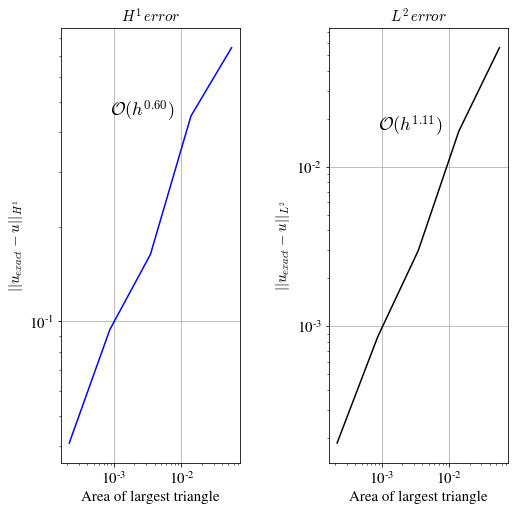

In [17]:
%matplotlib inline

def U_exact_2(x,y):

    return  np.sin(3*x)*np.cos(y) 


def F(x,y):
    
    return 10*np.sin(3*x)*np.cos(y)


# Square Domain
H1_error = []
L2_error = []
L_inf = []

Ns = red_refinement(4, 6)

Area = []
i = 0
for N in Ns[:-1]:
    E, Nodes, Mesh = Square_Triangulate(N)
    M = Stiffness(E, Nodes)
    [U, G_init] = Solve(Square_Triangulate, N, U_exact_2, F, on_boundary)
    X,Y = Nodes[E[0,1::],1], Nodes[E[0,1::],2]
    J = abs((X[1] - X[0])*(Y[2]-Y[0]) - (X[2]-X[0])*(Y[1]-Y[0]))
    Area.append(0.5*J)
    L_dom = Linear_interp(elements = E, nodes = Nodes, U = U)
    E_r, Nodes_r, Mesh_r = Square_Triangulate(Ns[i+1])
    
    U_refine = L_dom.eval(Nodes_r[:,1], Nodes_r[:,2])
    
    e_h1 = H1_norm(E_r, Nodes_r, U_refine-U_exact_2(Nodes_r[:,1], Nodes_r[:,2]))
    e_l2 = H1_norm(E_r, Nodes_r, U_refine-U_exact_2(Nodes_r[:,1], Nodes_r[:,2]), which = "L2")
    
    H1_error.append(e_h1)
    L2_error.append(e_l2)
    i+=1
    
    
#Convergence plots    
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8,8))
hs = np.array(Area)


m = np.log(H1_error[-1]/H1_error[-2])/np.log((hs[-1]/hs[-2]))
print(m)
ax[0].loglog(hs, H1_error, c = "b")
ax[0].text(hs[3], H1_error[1],r"$\mathcal{O}(h^{%1.2f})$" %(m), fontsize = 18)
ax[0].set_xlabel("Area of largest triangle", fontsize = 15)
ax[0].set_ylabel(r"$||u_{exact} - u||_{H^1}$", fontsize = 15)
ax[0].tick_params(axis='both', labelsize=15)
ax[0].set_title(r"$H^1 \, error$", fontsize = 15)
ax[0].grid()
plt.savefig("Plots_Assign3/Poisson_convergence.png")


m = np.log(L2_error[-1]/L2_error[-2])/np.log((hs[-1]/hs[-2]))
print(m)

ax[1].loglog(hs, L2_error, c = "k")
ax[1].text(hs[3], L2_error[1],r"$\mathcal{O}(h^{%1.2f})$" %(m), fontsize = 18)
ax[1].set_xlabel("Area of largest triangle", fontsize = 15)
ax[1].set_ylabel(r"$||u_{exact} - u||_{L^2}$", fontsize = 15)
ax[1].set_title(r"$L^2 \, error$", fontsize = 15)
ax[1].tick_params(axis='both', labelsize=15)
ax[1].grid()
plt.subplots_adjust(wspace = 0.5)
plt.savefig("Plots_Assign3/Poisson_convergence_L2.png")



Above are plots of the $H^1$ and $L^2$ errors vs. the area of the largest triangle in a log-log scale. Overlain is the estimated order of convergence. We can see that the $H^1$ norm exhibits about $0.4$ less for the order of convergence than was anticipated and the $L^2$ error exhibits almost a full order less. In order to determine if this is an artifact of our interpolation scheme, we also evaluate the same errors, along with the $L^{\infty}$, without refining the mesh and interpolating the solution. The results are given below: 

0.9991387872892514
0.9981446598728206
0.9995114610692653


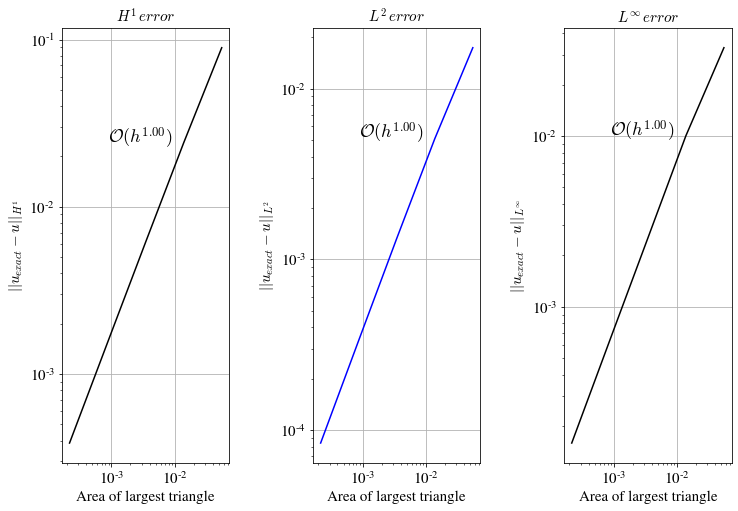

In [19]:
# Square Domain
H1_error = []
L2_error = []
L_inf = []

Ns = red_refinement(4, 5)
Area = []

for N in Ns:
    E, Nodes, Mesh = Square_Triangulate(N)
    M = Stiffness(E, Nodes)
    [U, G_init] = Solve(Square_Triangulate, N, U_exact_2, F, on_boundary)
    X,Y = Nodes[E[0,1::],1], Nodes[E[0,1::],2]
    J = abs((X[1] - X[0])*(Y[2]-Y[0]) - (X[2]-X[0])*(Y[1]-Y[0]))
    Area.append(0.5*J)

    e_h1 = H1_norm(E, Nodes, U-G_init)
    e_l2 = H1_norm(E, Nodes, U-G_init, which = "L2")
    L_inf.append(np.max(np.absolute(U-G_init)))
    H1_error.append(e_h1)
    L2_error.append(e_l2)
    
    
#Convergence plots    
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (12,8))
hs = Area


m = np.log(H1_error[-1]/H1_error[-2])/np.log((hs[-1]/hs[-2]))
print(m)
ax[0].loglog(hs, H1_error, c = "k")
ax[0].text(hs[3], H1_error[1],r"$\mathcal{O}(h^{%1.2f})$" %(m), fontsize = 18)
ax[0].set_xlabel("Area of largest triangle", fontsize = 15)
ax[0].set_ylabel(r"$||u_{exact} - u||_{H^1}$", fontsize = 15)
ax[0].tick_params(axis='both', labelsize=15)

ax[0].set_title(r"$H^1 \, error$", fontsize = 15)
ax[0].grid()
#plt.savefig("Plots_Assign3/Poisson_convergence.png")


m = np.log(L2_error[-1]/L2_error[-2])/np.log((hs[-1]/hs[-2]))
print(m)
ax[1].loglog(hs, L2_error, c = "b")
ax[1].text(hs[3], L2_error[1],r"$\mathcal{O}(h^{%1.2f})$" %(m), fontsize = 18)
ax[1].set_xlabel("Area of largest triangle", fontsize = 15)
ax[1].set_ylabel(r"$||u_{exact} - u||_{L^2}$", fontsize = 15)
ax[1].tick_params(axis='both', labelsize=15)

ax[1].set_title(r"$L^2 \, error$", fontsize = 15)
ax[1].grid()
plt.subplots_adjust(wspace = 0.5)
#plt.savefig("Plots_Assign3/Poisson_convergence_L2.png")


m = np.log(L_inf[-1]/L_inf[-2])/np.log((hs[-1]/hs[-2]))
print(m)
ax[2].loglog(hs, L_inf, c = "k")
ax[2].text(hs[3], L_inf[1],r"$\mathcal{O}(h^{%1.2f})$" %(m), fontsize = 18)
ax[2].set_xlabel("Area of largest triangle", fontsize = 15)
ax[2].set_ylabel(r"$||u_{exact} - u||_{L^{\infty}}$", fontsize = 15)
ax[2].tick_params(axis='both', labelsize=15)

ax[2].set_title(r"$L^{\infty} \, error$", fontsize = 15)
ax[2].grid()
plt.subplots_adjust(wspace = 0.5)
#plt.savefig("Plots_Assign3/Poisson_convergence_L_inf.png")

As we can see the interpolation affected the $H^1$-norm and had marginally decreased the $L^2$ error. Further investigation must be done to resolve the discrepancy in the theoretical order of convergence and numerical order of convergence in the $L^2$ norm.  

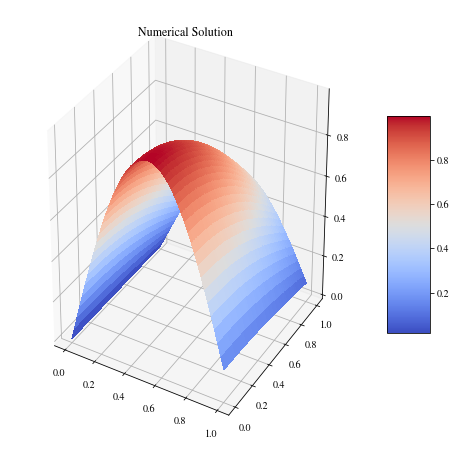

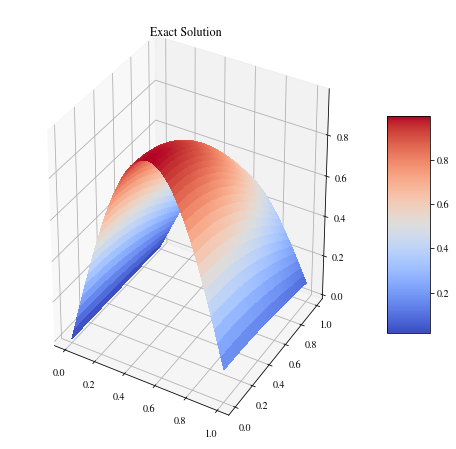

In [20]:
%matplotlib inline

fig = plt.figure(figsize = (8,8))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(Mesh[0], Mesh[1], U.reshape([N,N]), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title("Numerical Solution")

fig = plt.figure(figsize = (8,8))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(Mesh[0], Mesh[1], G_init.reshape([N,N]), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

plt.title("Exact Solution")

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.savefig("Plots_Assign3/G.png")

---

## <center> Domain with reentrant corner </center>

We now consider the same numerical experiment, except now on a domain with a reentrant corner. The particular domain is depicted below, followed by the implementation of the data structures.

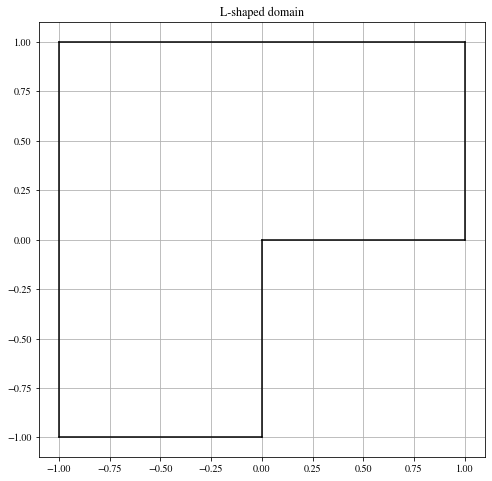

In [21]:
%matplotlib inline

fig = plt.figure(figsize = (8,8))
plt.plot([-1,0], [-1,-1], c = "k")
plt.plot([-1,-1], [-1,1], c = "k")
plt.plot([0,0], [-1,0], c = "k")
plt.plot([0,1], [0,0], c = "k")
plt.plot([1,1], [0,1], c = "k")
plt.plot([-1,1], [1,1], c = "k")
plt.grid()
plt.title("L-shaped domain")
plt.show()

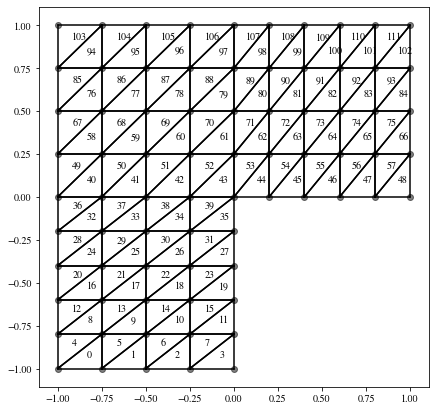

In [22]:
# %matplotlib inline
# # Triangulate domain with reentrant corner:

def L_Triangulate2(N):

    #stiching together three square domains, with corner at origin
    x_lower = np.linspace(-1, 0, N, endpoint = True)
    x_upper = np.linspace((1/N), 1, N, endpoint = True)
    y_lower = np.linspace(-1,0, N, endpoint = False)
    y_upper = np.linspace(0, 1, N, endpoint = True)

    #lower left quadrant
    [X_l,Y_l] = np.meshgrid(x_lower, y_lower)
    
    #upper part
    [X_u, Y_u] = np.meshgrid(list(x_lower) + list(x_upper), list(y_upper))
    X = list(X_l.reshape([int(N**2),])) + list(X_u.reshape([int(2*N**2),]))
    Y = list(Y_l.reshape([int(N**2),])) + list(Y_u.reshape([int(2*N**2),]))
    
    #combine the two lists
    M = len(X)
    Nodes = np.zeros([M, 3])
    Nodes[:,0], Nodes[:,1], Nodes[:,2] = np.arange(0, M, dtype = int), X, Y
    

    #separating lower and upper parts
    # Lower section  
    E_u1 = []
    E_u2 = []
    E_u3 = []
    for i in range(0, N):
        b = i*N  #beginning in nodes
        l_row = Nodes[b:b+N,0].copy()
        u_row = Nodes[b+N:b+2*N,0].copy()
        E_u1 += list(l_row[0:N-1])
        E_u2 += list(l_row[1:N])
        E_u3 += list(u_row[1:N])
        E_u1 += list(l_row[0:N-1])
        E_u2 += list(u_row[0:N-1])
        E_u3 += list(u_row[1:N])
        
          
    # Upper section 
    N_u = Nodes[N*N:, :].copy()
    NN = 2*N
    for i in range(0, N-1):
        b = i*NN  #beginning in nodes
        l_row = N_u[b:b+NN,0].copy()
        u_row = N_u[b+NN:b+2*NN,0].copy()
        E_u1 += list(l_row[0:NN-1])
        E_u2 += list(l_row[1:NN])
        E_u3 += list(u_row[1:NN])
        E_u1 += list(l_row[0:NN-1])
        E_u2 += list(u_row[0:NN-1])
        E_u3 += list(u_row[1:NN])
        
    
    M = len(E_u1)
    E = np.zeros([M, 4], dtype = int)  
    E[:,0] = np.arange(0, M, dtype = int) # "--------=----------"
    E[0:len(E_u1),1] = E_u1
    E[0:len(E_u2),2] = E_u2
    E[0:len(E_u3),3] = E_u3

    return E , Nodes, [X,Y]





E, Ns, Mesh = L_Triangulate2(5)

Mesh_Plot(E, Ns)



Above is the resulting triangulation of the L-shaped domain with elements labelled.

---
Using the same function as before we again compute the $H^1$ and $L^2$ error. This time we do not interpolate the solution and evaluate the error on the same mesh that the numerical solution was obtained, although the interpolation code is general enough to perform linear interpolation on the domain as well.

1.0155554590356215
1.0106087463661317


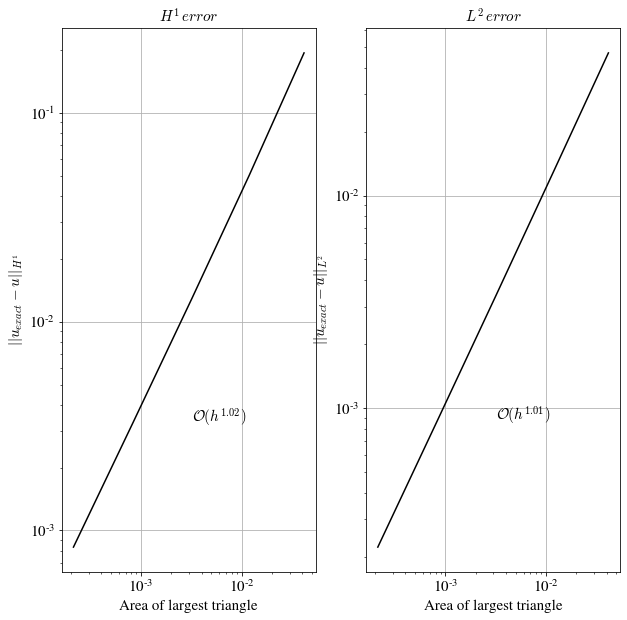

In [23]:
%matplotlib inline
# Define functions

def L_boundary(Nodes):
    bn = []
    eps = 1e-13
    for i in range(len(Nodes[:,0])):
        n, x, y = Nodes[i,0], Nodes[i,1], Nodes[i,2]
        if (y > (1-eps)) or (y < (-1 + eps)) or (x > (1-eps)) or (x < (-1 + eps)) \
        or (x > (0 - eps) and y < (0 + eps)):
            bn.append(int(n))

    return bn


def U_L_exact(x,y):
    U_ex = []
    for i in range(len(x)):
        uu = np.sin(3*x[i])*np.cos(y[i])
        U_ex.append(uu)
    
    return np.array(U_ex)

def F(x,y):
    return 10*np.sin(3*x)*np.cos(y)


H1_error = []
L2_error = []
Area = []
Ns = red_refinement(4, 5)
for N in Ns:
    E, Nodes, Mesh = L_Triangulate2(N)
    [U, G_init] = Solve(L_Triangulate2, N, U_L_exact, F, L_boundary, size = len(Mesh[0]))
    # Refinement procedure:
    X,Y = Nodes[E[0,1::],1], Nodes[E[0,1::],2]
    J = abs((X[1] - X[0])*(Y[2]-Y[0]) - (X[2]-X[0])*(Y[1]-Y[0]))
    Area.append(0.5*J)
    
    e_h1 = H1_norm(E, Nodes, U - G_init)
    e_l2 = H1_norm(E, Nodes, U - G_init, which = "L2")
    H1_error.append(e_h1)
    L2_error.append(e_l2)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,10))
    
hs = Area
m = np.log(H1_error[-2]/H1_error[-3])/np.log((hs[-2]/hs[-3]))
print(m)
ax[0].loglog(hs, H1_error, c = "k")
ax[0].text(hs[2], H1_error[-2],r"$\mathcal{O}(h^{%1.2f})$" %(m), fontsize = 15)
ax[0].set_xlabel("Area of largest triangle", fontsize = 15)
ax[0].set_ylabel(r"$||u_{exact} - u||_{H^1}$", fontsize = 15)
ax[0].tick_params(axis='both', labelsize=15)
ax[0].set_title(r"$H^1 \, error$", fontsize = 15)
ax[0].grid()
plt.savefig("Plots_Assign3/L_domain_Poisson_convergenceH1.png")


m = np.log(L2_error[-2]/L2_error[-3])/np.log((hs[-2]/hs[-3]))
print(m)
ax[1].loglog(hs, L2_error, c = "k")
ax[1].text(hs[2], L2_error[-2],r"$\mathcal{O}(h^{%1.2f})$" %(m), fontsize = 15)
ax[1].set_xlabel("Area of largest triangle", fontsize = 15)
ax[1].set_ylabel(r"$||u_{exact} - u||_{L^2}$", fontsize = 15)
ax[1].tick_params(axis='both', labelsize=15)
ax[1].set_title(r"$L^2 \, error$", fontsize = 15)
ax[1].grid()
plt.savefig("Plots_Assign3/L_domain_Poisson_convergence_L2.png")


The convergence rates from our numerical experiment with the convex domain are no longer the same, this is due to the lack of convexity in this domain. The previous estimates were based on the averaged Taylor polynomial over a convex domain. For elements near the origin, this averaging procedure breaks down. Moreover, for solutions to Poisson's equation in non-convex domain, the solution may not belong to $H^2$, instead having fractional regularity. In our current case, the solution does still belong to $H^2$, which is why we see a similar order of convergence to the convex domian. The effect of the non-convex domain is more pronounced for the proceeding numerical experiment for which we will analyze its effects in more detail.



---



We now consider a function of the form:

\begin{equation*}
u(r,\theta) = r^{2/3} \sin\left(\frac{2}{3} \theta\right)
\end{equation*}



In [24]:
# def rotate_L(Nodes):
#     # Apply rotation to Mesh and Nodes
#     Nodes_r = Nodes.copy()
#     Rot = np.array([[np.cos(-np.pi/2), -np.sin(-np.pi/2)],[np.sin(-np.pi/2), np.cos(np.pi/2)]])
#     for i in range(len(Nodes[:,0])):
#         Nodes_r[i,1::] = np.matmul(Rot, Nodes[i,1::])
    
    
#     return Nodes_r


# def L_boundary_R(Nodes):
#     bn = []
#     eps = 1e-13
#     for i in range(len(Nodes[:,0])):
#         n, x, y = Nodes[i,0], Nodes[i,1], Nodes[i,2]
#         if (y > (1-eps)) or (y < (-1 + eps)) or (x > (1-eps)) or (x < (-1 + eps)) \
#         or (x < (0 + eps) and y < (0 + eps)):
#             bn.append(int(n))

#     return bn

# E, Ns, Mesh = L_Triangulate2(5)
# Ns = rotate_L(Ns)
# bound = L_boundary_R(Ns)
# Mesh_Plot(E, Ns, bound)

-0.2860704666361448
-0.0392784425982671
-0.07594102222940159


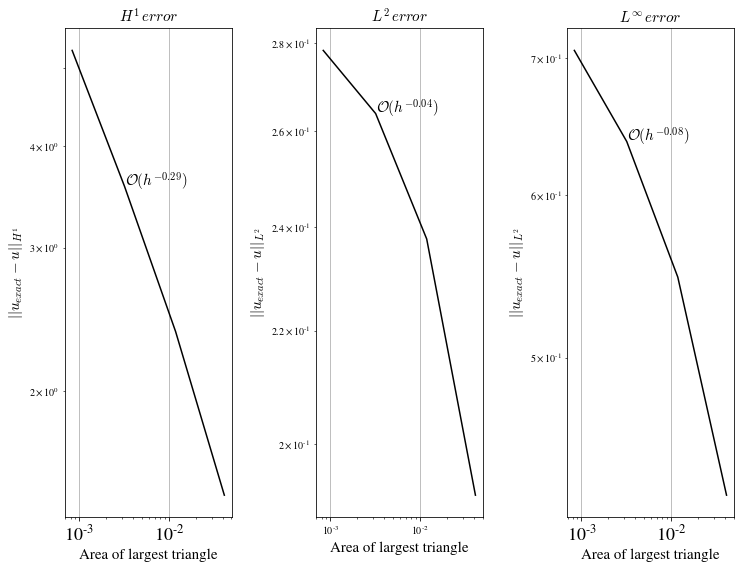

In [32]:
#L-shaped domain

def u_r_exact(X,Y):
    u_ex = []
    for i in range(len(X)):
        x,y = X[i], Y[i]
        u_ex.append(((x**2 + y**2)**(1/3))*np.sin((2/3)*np.arctan2(y,x)))
        
    return np.array(u_ex)


def Zero_F(x,y):
    F = 0*np.absolute(x)
    return F

# Square Domain
H1_error = []
L2_error = []
L_inf = []
Area = []

Ns = red_refinement(4, 4)
for N in Ns:
    E, Nodes, Mesh = L_Triangulate2(N)
    [U, G_init] = Solve(L_Triangulate2, N, U_exact = u_r_exact, 
                        F = Zero_F, boundary = L_boundary, size = len(Mesh[0]))
    X,Y = Nodes[E[0,1::],1], Nodes[E[0,1::],2]    
    J = abs((X[1] - X[0])*(Y[2]-Y[0]) - (X[2]-X[0])*(Y[1]-Y[0]))
    Area.append(0.5*J)   
    e_h1 = H1_norm(E, Nodes, U - G_init)
    e_l2 = H1_norm(E, Nodes, U - u_r_exact(Nodes[:,1], Nodes[:,2]), which = "L2")
    
    H1_error.append(e_h1)
    L2_error.append(e_l2)
    L_inf.append(np.max(np.absolute(U-G_init)))

#     Error = U - G_init
#     #Plot the error of the solution
#     X = Nodes[:,1]
#     Y = Nodes[:,2]
   
#     fig2 = plt.figure(figsize = (10,10))
#     ax = plt.axes()#projection='3d')
#     # ax.plot_trisurf(X, Y, U,
#     #                 cmap='viridis', edgecolor='none')

#     ax.tricontourf(X, Y, Error, levels=100, cmap="RdBu_r")
#     #ax.view_init(90, 0)

#     plt.show()

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (12,9))
    
hs = Area
m = np.log(H1_error[-1]/H1_error[-2])/np.log((hs[-1]/hs[-2]))
print(m)
ax[0].loglog(hs, H1_error, c = "k")
ax[0].text(hs[2], H1_error[-2],r"$\mathcal{O}(h^{%1.2f})$" %(m), fontsize = 15)
ax[0].set_xlabel("Area of largest triangle", fontsize = 15)
ax[0].set_ylabel(r"$||u_{exact} - u||_{H^1}$", fontsize = 15)
ax[0].set_title(r"$H^1 \, error$", fontsize = 15)
ax[0].tick_params(axis='both', labelsize=18)
ax[0].grid()
plt.savefig("Plots_Assign3/radial_Poisson_convergenceH1.png")


m = np.log(L2_error[-1]/L2_error[-2])/np.log((hs[-1]/hs[-2]))
print(m)
ax[1].loglog(hs, L2_error, c = "k")
ax[1].text(hs[2], L2_error[-2],r"$\mathcal{O}(h^{%1.2f})$" %(m), fontsize = 15)
ax[1].set_xlabel("Area of largest triangle", fontsize = 15)
ax[1].set_ylabel(r"$||u_{exact} - u||_{L^2}$", fontsize = 15)
ax[1].set_title(r"$L^2 \, error$", fontsize = 15)
ax[1].grid()
plt.subplots_adjust(wspace = 0.5)
plt.savefig("Plots_Assign3/radial_Poisson_convergence_L2.png")

m = np.log(L_inf[-1]/L_inf[-2])/np.log((hs[-1]/hs[-2]))
print(m)
ax[2].loglog(hs, L_inf, c = "k")
ax[2].text(hs[2], L_inf[-2],r"$\mathcal{O}(h^{%1.2f})$" %(m), fontsize = 15)
ax[2].set_xlabel("Area of largest triangle", fontsize = 15)
ax[2].set_ylabel(r"$||u_{exact} - u||_{L^2}$", fontsize = 15)
ax[2].set_title(r"$L^{\infty} \, error$", fontsize = 15)
ax[2].tick_params(axis='both', labelsize=18)
ax[2].grid()
plt.subplots_adjust(wspace = 0.5)
plt.savefig("Plots_Assign3/radial_Poisson_convergence_Linf.png")



It is observed that the solution diverges, although this is not what should be happen based on the theoretical results we will outline below. Had the solver exhibited the correct order of convergence for both the $H^1$ and $L^2$ norms then this divergence would hint toward an different error in our implementation for the L-shaped domain. Since this was not the case, we suppose that this divergence occurs for the same reason that our solver did not exhibit the correct order of convergence for the square domain. 

We end this assignment by addressing in which Sobolev space the question of which space the solution should be found and how this can be measured. We note that,

\begin{equation*}
\begin{aligned}
\left\lvert u(r, \theta) \right \rvert_{W^{k,2}(\Omega)} &\approx \int_0^1 (r^{2/3 - k})^2 r \rm{d}r
\\
& = \int_0^1 r^{4/3 - 2k +1} \rm{d}r = \frac{1}{4/3 - 2k + 2}r^{4/3 - 2k + 2} \bigg\rvert^1_0
\end{aligned}
\end{equation*}

which converges for $k \leq 5/3$. Thus our solution $u(r,\theta) \in H^{5/3}(\Omega)$, has fractional regularity less than 2 and hence why the bound for the square domain does not hold in this case. In order to answer what our approximate order of convergence should be, we will use the abstract approximation theory seen in class and the FEM convergence estimates outlined in section 14.3 of [3]. We employ the following theorem form [3] (14.3.3). Supposing that $u \in H^m(\Omega)$ and that their exists a suitable interpolant such that the following estimate, 

\begin{equation*}
\lVert u - u_h\rVert_{H^m} \leq Ch^{k-m} \lVert u \rVert_{H^k}  \,\,\,\,\,\,\,\,\, (*)
\end{equation*}

to hold for any $u \in H^k(\Omega)$. Then, letting $m < s <k$, the following,

\begin{equation*}
\lVert u - u_h\rVert_{H^m} \leq Ch^{s-m}\lVert u \rVert_{H^s}
\end{equation*}

for any $u \in H^s$. 

*Proof*:
Let $T$ be the operator mapping $u \mapsto u- u_h$. Then we have that,

\begin{equation*}
\begin{aligned}
\lVert u - u_h \rVert_{H^m} & = \lVert Tu \rVert_{H^m} \leq c_1 h^{k-m}\lVert u \rVert_{H^m}
\\
&\Rightarrow \lVert T \rVert_{H^m \rightarrow H^k} \leq c_1h^{k-m} 
\end{aligned}
\end{equation*}

Moreover, using Cea's Lemma, by setting $v = 0$, we have that 

\begin{equation*}
\begin{aligned}
\lVert u - u_h \rVert_{H^m} &\leq c_0 \inf_{v \in V^h} \lVert u - v \rVert_{H^m} \leq c_0 \lVert u \rVert_{H^m}
\\
& \Rightarrow \lVert T \rVert_{H^m \rightarrow H^m} \leq c_0
\end{aligned}
\end{equation*}

Therefore we can apply the Banach space interpolation theorem, where for pairs of Banach spaces $A_i, B_i$ $(i = 0,1)$, and a bounded operator $T$ between them, the following estimate holds

\begin{equation*}
\lVert T \rVert_{A_{\theta, p} \rightarrow B_{\theta_p}} \leq \lVert T \rVert_{A_0 \rightarrow B_0}^{1-\theta} \lVert T \rVert_{A_1 \rightarrow B_1}^{\theta}
\end{equation*}

Then setting $A_0 = B_0 = B_1 = H^m$ and $A_1 = H^k$, and noting that $s = m(1-\theta) + \theta k$, we get that 

\begin{equation*}
\lVert T \rVert_{H^s \rightarrow H^m} \leq C h^{(k-m)\theta} = Ch^{s-m}.
\end{equation*}

Now that this estimate is established, we can conclude the following (Theorem 14.3.5 of [3]). Supposing that Cea's Lemma holds for all $u \in H^m$ and that $(*)$ holds for any $u \in H^k$. Then, letting $m < s<k$, we have that 


\begin{equation}
\lVert u - u_h \rVert_{H^m} = \mathcal{o}(h^{s-m})
\end{equation}

holds for all $u \in H^s(\Omega)$.

*Proof*. Using the definition of $T$ from the preceeding theorem, and letting $v \in H^k$, we have that

\begin{equation*}
\begin{aligned}
\lVert u- u_h \rVert_{H^m} &\leq \lVert Tu - Tv \rVert_{H^m} + \lVert Tv \rVert_{H^m}
\\
& \leq c_o \lVert u-v \rVert_{H^m} + c_1 h^{k-m}\lVert v \rVert_{H^k}
\end{aligned}
\end{equation*}

Then taking the infimum over all $v \in H^k(\Omega)$. We get that,

\begin{equation*}
\lVert u - u_h \rVert_{H^m} \leq c_0 K(u, (c_1/c_0)h^{k-m}) = \mathcal{o}(h^{(k-m)\theta})
\end{equation*}

Here, $\theta$ is determined by $u \in W^{\theta, p} = W^{\theta,2}$ with, $\theta = (s-m)/(k-m)$. Thus,

\begin{equation*}
\lVert u - u_h \rVert_{H^m} = \mathcal{o}(h^{s-m})
\end{equation*}

The upshot begin that if we measure our error in the $H^1$ norm then we expect the order of convergence to be $\approx 2/3 - \epsilon$ and the order of convergence as measured in the $L^2$ norm to be $\approx 5/3 - \epsilon$ for $\epsilon$ small. 

<!-- 
\begin{equation*}
\mathcal{A}^{\alpha}_{2} = \left[ L^2, W^{m,2} \right ]_{\frac{\alpha}{m}, 2} = H^{\alpha}
\end{equation*}

and using the reiteration theorem, we have that

\begin{equation*}
\mathcal{A}^{\alpha}_{2}(H^1) = H^{1 + \alpha}
\end{equation*} -->

---

---
**References**:

[1]: Alberty, Jochen, Carsten Carstensen, and Stefan A. Funken. "Remarks around 50 lines of Matlab: short finite element implementation." Numerical algorithms 20.2-3 (1999): 117-137.

[2]: Larson, Mats G., and Fredrik Bengzon. "The finite element method: theory, implementation, and practice." Texts in Computational Science and Engineering 10 (2010).

[3]: Brenner, Susanne, and Ridgway Scott. The mathematical theory of finite element methods. Vol. 15. Springer Science & Business Media, 2007.